## Prediction index of NASDAQ using RNN(LSTM)

We extract the dataset directly from the web yahoo finance selecting the value '^NDX'

LSTM, Long short term memory cells are used to predict the Close value index

In [1]:

# yfinance is a popular open source library to access the financial data available on Yahoo Finance
# https://pypi.org/project/yfinance/

import yfinance as yf

# typical library to plot and manipulate data

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Normalize the data

from sklearn.preprocessing import StandardScaler

# keras to model and predict the data.

from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.callbacks import ModelCheckpoint 

# Extraction

We extract the value '^NDX' for 5 years using the method Ticker from yfinance library. We can select other values: 
AMAZON(AMZN), Ibex(^IBEX), Google(GOOG),...

In [2]:
msft = yf.Ticker("^NDX")

df = msft.history(period="6y")
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-05-06,4420.299805,4429.959961,4349.930176,4379.750000,2144620000,0,0
2015-05-07,4377.810059,4413.729980,4373.290039,4401.549805,2042960000,0,0
2015-05-08,4445.000000,4466.169922,4441.729980,4458.649902,1978760000,0,0
2015-05-11,4457.620117,4468.750000,4437.529785,4438.640137,1731390000,0,0
2015-05-12,4412.819824,4441.399902,4380.520020,4420.649902,1705870000,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-05-06 to 2021-05-05
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1511 non-null   float64
 1   High          1511 non-null   float64
 2   Low           1511 non-null   float64
 3   Close         1511 non-null   float64
 4   Volume        1511 non-null   int64  
 5   Dividends     1511 non-null   int64  
 6   Stock Splits  1511 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 94.4 KB


In [4]:
# We select the 'Close' column

df_final = pd.DataFrame(df.iloc[:,3])
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-05-06 to 2021-05-05
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1511 non-null   float64
dtypes: float64(1)
memory usage: 23.6 KB


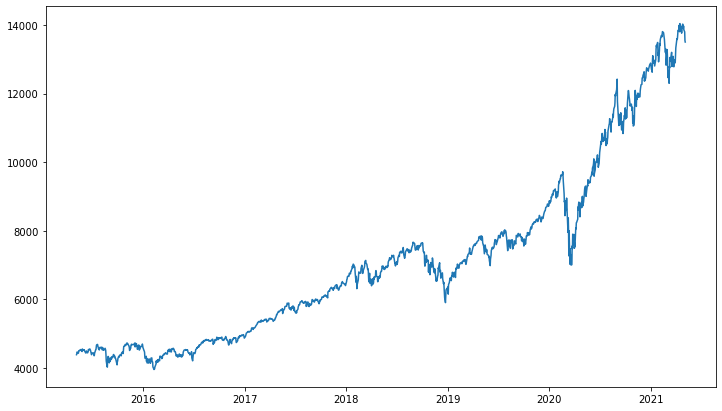

In [5]:
# we plot the time series at the begining to now

plt.figure(figsize=(12,7))

plt.plot(df_final['Close'])
plt.show()

# Train and Test

Split the df in train (values to 2020) and test (values from 2021) 

In [6]:

train = df_final[:'2020'].iloc[:,0:1].reset_index()
test = df_final['2021':].iloc[:,0:1].reset_index()

print(train.shape)
print(test.shape)
print(train.head())
print(train.info())

(1426, 2)
(85, 2)
        Date        Close
0 2015-05-06  4379.750000
1 2015-05-07  4401.549805
2 2015-05-08  4458.649902
3 2015-05-11  4438.640137
4 2015-05-12  4420.649902
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1426 entries, 0 to 1425
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1426 non-null   datetime64[ns]
 1   Close   1426 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.4 KB
None


# Standardize features

In [7]:

scale = StandardScaler()

# df sólo con numéricas
train_n = train._get_numeric_data()
scale.fit(train_n)

# df escalado
train_scaled = scale.fit_transform(train_n)
train_scaled

array([[-1.11954147],
       [-1.10924325],
       [-1.08226921],
       ...,
       [ 2.87872364],
       [ 2.87960708],
       [ 2.89988242]])

# LSTM

We create different subset of data to estimate the last one. We collect the value in the variable 'step' to modify and test different values. We split the df train and test using the previous variale 'step'

In [8]:

step = 50

X_train = []
Y_train = []
m = len(train_scaled)
print(m)

for i in range(step,m):
    # X: set de "step" datos: 0-step, 1-step+1, 2-step+2, etc
    X_train.append(train_scaled[i-step:i])

    # Y: The last data is loaded in Y_train
    Y_train.append(train_scaled[i])

X_train, Y_train = np.array(X_train), np.array(Y_train)

print(X_train.shape)
print(Y_train.shape)

#print(X_train)

1426
(1376, 50, 1)
(1376, 1)


In [9]:
# Reshape X_train to adjust the model Keras (step x 1)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1))

# It's regression process, we use loss 'mse' (mean square error) and use 'adam' a mixture between RMSprop and Momentun
model.compile(optimizer='RMSprop',
              loss='mse')

# Number of parameter
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
activation (Activation)      (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [10]:
checkpointer = ModelCheckpoint(filepath='stock_lstm.hdf5', 
                               verbose=1, save_best_only=True)

# We train the model with 50 epochs
epochs=50
history = model.fit(X_train,Y_train,
                    epochs=epochs,
                    batch_size=30,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/50
46/46 [==============================] - 2s 14ms/step - loss: 0.3911
Epoch 2/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0468
Epoch 3/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0301
Epoch 4/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0243
Epoch 5/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0294
Epoch 6/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0291
Epoch 7/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0244
Epoch 8/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0225
Epoch 9/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0213
Epoch 10/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0218
Epoch 11/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0202
Epoch 12/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0262
Epoch 13/50
46/46 [==================

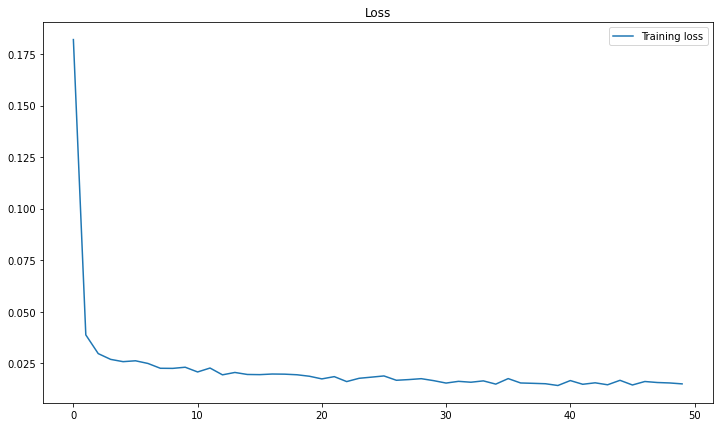

In [11]:
plt.figure(figsize=(12,7))
loss = history.history['loss']

plt.plot(range(len(loss)),loss, label='Training loss')
plt.title('Loss')
plt.legend()

plt.show()

In [12]:
# Normalize the test data

x_test = test._get_numeric_data()
x_test = scale.transform(x_test)

In [18]:
X_test = []
for i in range(step,len(x_test)):
    X_test.append(x_test[i-step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

# we predict the data and transform the origin dim

predict = model.predict(X_test)
predict = scale.inverse_transform(predict)
print(len(predict))
print(len(test))

35
85


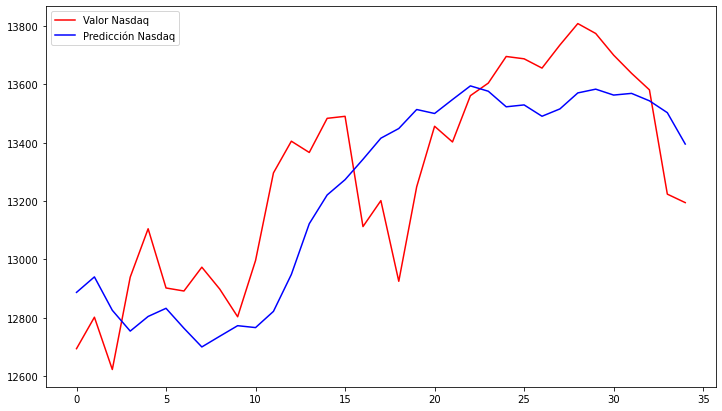

In [14]:
plt.figure(figsize=(12,7))

plt.plot(test.Close[0:len(predict)],color='red', label='Valor Nasdaq')
plt.plot(predict, color='blue', label='Predicción Nasdaq')
plt.legend()
plt.show()